To run this, press "*Runtime*" and press "*Run all*" on a **free** Tesla T4 Google Colab instance!
<div class="align-center">
<a href="https://unsloth.ai/"><img src="https://github.com/unslothai/unsloth/raw/main/images/unsloth%20new%20logo.png" width="115"></a>
<a href="https://discord.gg/unsloth"><img src="https://github.com/unslothai/unsloth/raw/main/images/Discord button.png" width="145"></a>
<a href="https://docs.unsloth.ai/"><img src="https://github.com/unslothai/unsloth/blob/main/images/documentation%20green%20button.png?raw=true" width="125"></a></a> Join Discord if you need help + ⭐ <i>Star us on <a href="https://github.com/unslothai/unsloth">Github</a> </i> ⭐
</div>

To install Unsloth on your own computer, follow the installation instructions on our Github page [here](https://docs.unsloth.ai/get-started/installing-+-updating).

You will learn how to do [data prep](#Data), how to [train](#Train), how to [run the model](#Inference), & [how to save it](#Save)


### News


Unsloth's [Docker image](https://hub.docker.com/r/unsloth/unsloth) is here! Start training with no setup & environment issues. [Read our Guide](https://docs.unsloth.ai/new/how-to-train-llms-with-unsloth-and-docker).

[gpt-oss RL](https://docs.unsloth.ai/new/gpt-oss-reinforcement-learning) is now supported with the fastest inference & lowest VRAM. Try our [new notebook](https://colab.research.google.com/github/unslothai/notebooks/blob/main/nb/gpt-oss-(20B)-GRPO.ipynb) which creates kernels!

Introducing [Vision](https://docs.unsloth.ai/new/vision-reinforcement-learning-vlm-rl) and [Standby](https://docs.unsloth.ai/basics/memory-efficient-rl) for RL! Train Qwen, Gemma etc. VLMs with GSPO - even faster with less VRAM.

Unsloth now supports Text-to-Speech (TTS) models. Read our [guide here](https://docs.unsloth.ai/basics/text-to-speech-tts-fine-tuning).

Visit our docs for all our [model uploads](https://docs.unsloth.ai/get-started/all-our-models) and [notebooks](https://docs.unsloth.ai/get-started/unsloth-notebooks).


### Installation

In [1]:
%%capture
import os, re
if "COLAB_" not in "".join(os.environ.keys()):
    !pip install unsloth
else:
    # Do this only in Colab notebooks! Otherwise use pip install unsloth
    import torch; v = re.match(r"[0-9\.]{3,}", str(torch.__version__)).group(0)
    xformers = "xformers==" + ("0.0.32.post2" if v == "2.8.0" else "0.0.29.post3")
    !pip install --no-deps bitsandbytes accelerate {xformers} peft trl triton cut_cross_entropy unsloth_zoo
    !pip install sentencepiece protobuf "datasets>=3.4.1,<4.0.0" "huggingface_hub>=0.34.0" hf_transfer
    !pip install --no-deps unsloth
!pip install transformers==4.55.4
!pip install --no-deps trl==0.22.2

In [2]:
!pip -q install wandb
import wandb, os
wandb.login()          # or: wandb.login(anonymous="allow")
os.environ["WANDB_NOTEBOOK_NAME"] = "CS678_HW2_SFT.ipynb"


/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: srisashankpotluri (srisashankpotluri-george-mason-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


### Unsloth

In [2]:
from unsloth import FastLanguageModel
import torch
max_seq_length = 2048 # Choose any! We auto support RoPE Scaling internally!
dtype = None # None for auto detection. Float16 for Tesla T4, V100, Bfloat16 for Ampere+
load_in_4bit = True # Use 4bit quantization to reduce memory usage. Can be False.

# 4bit pre quantized models we support for 4x faster downloading + no OOMs.
fourbit_models = [
    "unsloth/Meta-Llama-3.1-8B-bnb-4bit",      # Llama-3.1 2x faster
    "unsloth/Meta-Llama-3.1-8B-Instruct-bnb-4bit",
    "unsloth/Meta-Llama-3.1-70B-bnb-4bit",
    "unsloth/Meta-Llama-3.1-405B-bnb-4bit",    # 4bit for 405b!
    "unsloth/Mistral-Small-Instruct-2409",     # Mistral 22b 2x faster!
    "unsloth/mistral-7b-instruct-v0.3-bnb-4bit",
    "unsloth/Phi-3.5-mini-instruct",           # Phi-3.5 2x faster!
    "unsloth/Phi-3-medium-4k-instruct",
    "unsloth/gemma-2-9b-bnb-4bit",
    "unsloth/gemma-2-27b-bnb-4bit",            # Gemma 2x faster!

    "unsloth/Llama-3.2-1B-bnb-4bit",           # NEW! Llama 3.2 models
    "unsloth/Llama-3.2-1B-Instruct-bnb-4bit",
    "unsloth/Llama-3.2-3B-bnb-4bit",
    "unsloth/Llama-3.2-3B-Instruct-bnb-4bit",

    "unsloth/Llama-3.3-70B-Instruct-bnb-4bit" # NEW! Llama 3.3 70B!
] # More models at https://huggingface.co/unsloth

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "unsloth/Llama-3.2-3B-Instruct", # or choose "unsloth/Llama-3.2-1B-Instruct"
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,
    # token = "hf_...", # use one if using gated models like meta-llama/Llama-2-7b-hf
)

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!
==((====))==  Unsloth 2025.10.1: Fast Llama patching. Transformers: 4.55.4.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.8.0+cu126. CUDA: 7.5. CUDA Toolkit: 12.6. Triton: 3.4.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.32.post2. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/1.46G [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/234 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/454 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.2M [00:00<?, ?B/s]

chat_template.jinja: 0.00B [00:00, ?B/s]

We now add LoRA adapters so we only need to update 1 to 10% of all parameters!

In [12]:
model = FastLanguageModel.get_peft_model(
    model,
    r = 16, # Choose any number > 0 ! Suggested 8, 16, 32, 64, 128
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj",],
    lora_alpha = 16,
    lora_dropout = 0, # Supports any, but = 0 is optimized
    bias = "none",    # Supports any, but = "none" is optimized
    # [NEW] "unsloth" uses 30% less VRAM, fits 2x larger batch sizes!
    use_gradient_checkpointing = "unsloth", # True or "unsloth" for very long context
    random_state = 3407,
    use_rslora = False,  # We support rank stabilized LoRA
    loftq_config = None, # And LoftQ
)

<a name="Data"></a>
### Data Prep
We now use the `Llama-3.1` format for conversation style finetunes. We use [Maxime Labonne's FineTome-100k](https://huggingface.co/datasets/mlabonne/FineTome-100k) dataset in ShareGPT style. But we convert it to HuggingFace's normal multiturn format `("role", "content")` instead of `("from", "value")`/ Llama-3 renders multi turn conversations like below:

```
<|begin_of_text|><|start_header_id|>user<|end_header_id|>

Hello!<|eot_id|><|start_header_id|>assistant<|end_header_id|>

Hey there! How are you?<|eot_id|><|start_header_id|>user<|end_header_id|>

I'm great thanks!<|eot_id|>
```

We use our `get_chat_template` function to get the correct chat template. We support `zephyr, chatml, mistral, llama, alpaca, vicuna, vicuna_old, phi3, llama3` and more.

In [14]:
from unsloth.chat_templates import get_chat_template

tokenizer = get_chat_template(
    tokenizer,
    chat_template = "llama-3.1",
)

def formatting_prompts_func(examples):
    convos = examples["conversations"]
    texts = [tokenizer.apply_chat_template(convo, tokenize = False, add_generation_prompt = False) for convo in convos]
    return { "text" : texts, }

from datasets import load_dataset
dataset = load_dataset("mlabonne/FineTome-100k", split = "train")

We now use `standardize_sharegpt` to convert ShareGPT style datasets into HuggingFace's generic format. This changes the dataset from looking like:
```
{"from": "system", "value": "You are an assistant"}
{"from": "human", "value": "What is 2+2?"}
{"from": "gpt", "value": "It's 4."}
```
to
```
{"role": "system", "content": "You are an assistant"}
{"role": "user", "content": "What is 2+2?"}
{"role": "assistant", "content": "It's 4."}
```

In [15]:
from unsloth.chat_templates import standardize_sharegpt
dataset = standardize_sharegpt(dataset)
dataset = dataset.map(formatting_prompts_func, batched = True,)

Map:   0%|          | 0/100000 [00:00<?, ? examples/s]

We look at how the conversations are structured for item 5:

In [16]:
dataset[5]["conversations"]

[{'content': 'How do astronomers determine the original wavelength of light emitted by a celestial body at rest, which is necessary for measuring its speed using the Doppler effect?',
  'role': 'user'},
 {'content': 'Astronomers make use of the unique spectral fingerprints of elements found in stars. These elements emit and absorb light at specific, known wavelengths, forming an absorption spectrum. By analyzing the light received from distant stars and comparing it to the laboratory-measured spectra of these elements, astronomers can identify the shifts in these wavelengths due to the Doppler effect. The observed shift tells them the extent to which the light has been redshifted or blueshifted, thereby allowing them to calculate the speed of the star along the line of sight relative to Earth.',
  'role': 'assistant'}]

And we see how the chat template transformed these conversations.

**[Notice]** Llama 3.1 Instruct's default chat template default adds `"Cutting Knowledge Date: December 2023\nToday Date: 26 July 2024"`, so do not be alarmed!

In [17]:
dataset[5]["text"]

'<|begin_of_text|><|start_header_id|>system<|end_header_id|>\n\nCutting Knowledge Date: December 2023\nToday Date: 26 July 2024\n\n<|eot_id|><|start_header_id|>user<|end_header_id|>\n\nHow do astronomers determine the original wavelength of light emitted by a celestial body at rest, which is necessary for measuring its speed using the Doppler effect?<|eot_id|><|start_header_id|>assistant<|end_header_id|>\n\nAstronomers make use of the unique spectral fingerprints of elements found in stars. These elements emit and absorb light at specific, known wavelengths, forming an absorption spectrum. By analyzing the light received from distant stars and comparing it to the laboratory-measured spectra of these elements, astronomers can identify the shifts in these wavelengths due to the Doppler effect. The observed shift tells them the extent to which the light has been redshifted or blueshifted, thereby allowing them to calculate the speed of the star along the line of sight relative to Earth.<|

<a name="Train"></a>
### Train the model
Now let's train our model. We do 60 steps to speed things up, but you can set `num_train_epochs=1` for a full run, and turn off `max_steps=None`. We also support TRL's `DPOTrainer`!

In [18]:
from trl import SFTConfig, SFTTrainer
from transformers import DataCollatorForSeq2Seq
from unsloth.chat_templates import train_on_responses_only

data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, label_pad_token_id=-100)

trainer = SFTTrainer(
    model=model,
    tokenizer=tokenizer,
    train_dataset=dataset,
    dataset_text_field="text",
    max_seq_length=max_seq_length,
    data_collator=data_collator,
    packing=False,
    args=SFTConfig(
        per_device_train_batch_size=2,
        gradient_accumulation_steps=4,
        warmup_steps=5,
        max_steps=60,                # or num_train_epochs=1
        learning_rate=2e-4,
        logging_strategy="steps",
        logging_steps=1,
        optim="adamw_8bit",
        weight_decay=0.01,
        lr_scheduler_type="linear",
        seed=3407,
        output_dir="outputs",
        report_to="wandb",           # <—
        run_name="llama3.2-3b-sft-demo2",
    ),
    dataset_kwargs={"add_special_tokens": False},
)

trainer = train_on_responses_only(
    trainer,
    instruction_part = "<|start_header_id|>user<|end_header_id|>\n\n",
    response_part    = "<|start_header_id|>assistant<|end_header_id|>\n\n",
)


Unsloth: Tokenizing ["text"] (num_proc=6):   0%|          | 0/100000 [00:00<?, ? examples/s]

Map (num_proc=2):   0%|          | 0/100000 [00:00<?, ? examples/s]

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 100,000 | Num Epochs = 1 | Total steps = 60
O^O/ \_/ \    Batch size per device = 2 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (2 x 4 x 1) = 8
 "-____-"     Trainable parameters = 24,313,856 of 3,237,063,680 (0.75% trained)


Step,Training Loss
1,0.768700
2,0.825000
3,1.076500
4,0.876100
5,0.749500
6,0.922500
7,0.610700
8,0.982400
9,0.846600
10,0.746300


Lowest training loss at step: 51
Training loss: 0.449
Training time (minutes): 6.69
Saved: training_loss.png


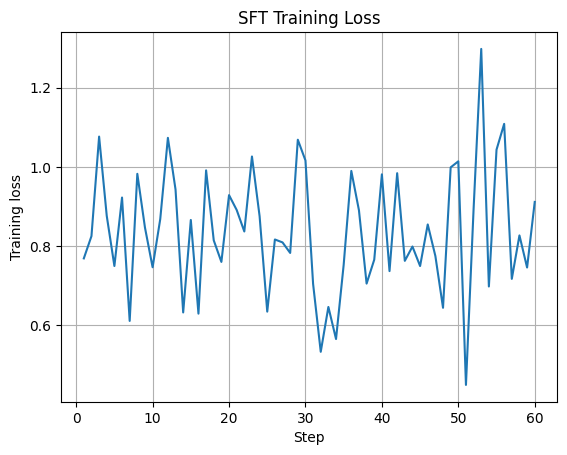

In [19]:
import time, matplotlib.pyplot as plt

t0 = time.time()
train_result = trainer.train()
mins = (time.time() - t0) / 60.0

logs = [e for e in trainer.state.log_history if "loss" in e and "learning_rate" in e]
best = min(logs, key=lambda d: d["loss"])
print("Lowest training loss at step:", best["step"])
print("Training loss:", round(best["loss"], 4))
print("Training time (minutes):", round(mins, 2))

# optional local figure for the PDF
steps, losses = [d["step"] for d in logs], [d["loss"] for d in logs]
plt.figure(); plt.plot(steps, losses); plt.xlabel("Step"); plt.ylabel("Training loss"); plt.title("SFT Training Loss"); plt.grid(True)
plt.savefig("training_loss.png", dpi=220, bbox_inches="tight")
print("Saved: training_loss.png")


We also use Unsloth's `train_on_completions` method to only train on the assistant outputs and ignore the loss on the user's inputs.

In [ ]:
from unsloth.chat_templates import train_on_responses_only
trainer = train_on_responses_only(
    trainer,
    instruction_part = "<|start_header_id|>user<|end_header_id|>\n\n",
    response_part = "<|start_header_id|>assistant<|end_header_id|>\n\n",
)

Map:   0%|          | 0/100000 [00:00<?, ? examples/s]

We verify masking is actually done:

In [ ]:
tokenizer.decode(trainer.train_dataset[5]["input_ids"])

'<|begin_of_text|><|start_header_id|>system<|end_header_id|>\n\nCutting Knowledge Date: December 2023\nToday Date: 26 July 2024\n\n<|eot_id|><|start_header_id|>user<|end_header_id|>\n\nHow do astronomers determine the original wavelength of light emitted by a celestial body at rest, which is necessary for measuring its speed using the Doppler effect?<|eot_id|><|start_header_id|>assistant<|end_header_id|>\n\nAstronomers make use of the unique spectral fingerprints of elements found in stars. These elements emit and absorb light at specific, known wavelengths, forming an absorption spectrum. By analyzing the light received from distant stars and comparing it to the laboratory-measured spectra of these elements, astronomers can identify the shifts in these wavelengths due to the Doppler effect. The observed shift tells them the extent to which the light has been redshifted or blueshifted, thereby allowing them to calculate the speed of the star along the line of sight relative to Earth.<|

In [ ]:
space = tokenizer(" ", add_special_tokens = False).input_ids[0]
tokenizer.decode([space if x == -100 else x for x in trainer.train_dataset[5]["labels"]])

'                                                                \n\nAstronomers make use of the unique spectral fingerprints of elements found in stars. These elements emit and absorb light at specific, known wavelengths, forming an absorption spectrum. By analyzing the light received from distant stars and comparing it to the laboratory-measured spectra of these elements, astronomers can identify the shifts in these wavelengths due to the Doppler effect. The observed shift tells them the extent to which the light has been redshifted or blueshifted, thereby allowing them to calculate the speed of the star along the line of sight relative to Earth.<|eot_id|>'

We can see the System and Instruction prompts are successfully masked!

In [ ]:
# @title Show current memory stats
gpu_stats = torch.cuda.get_device_properties(0)
start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)
print(f"GPU = {gpu_stats.name}. Max memory = {max_memory} GB.")
print(f"{start_gpu_memory} GB of memory reserved.")

GPU = Tesla T4. Max memory = 14.748 GB.
2.635 GB of memory reserved.


In [ ]:
trainer_stats = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 100,000 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 2 | Gradient Accumulation steps = 4
\        /    Total batch size = 8 | Total steps = 60
 "-____-"     Number of trainable parameters = 24,313,856


Step,Training Loss
1,0.826200
2,0.811700
3,1.132200
4,0.927300
5,0.775200
6,0.967900
7,0.630600
8,1.027400
9,0.788400
10,0.753300


In [ ]:
# @title Show final memory and time stats
used_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
used_memory_for_lora = round(used_memory - start_gpu_memory, 3)
used_percentage = round(used_memory / max_memory * 100, 3)
lora_percentage = round(used_memory_for_lora / max_memory * 100, 3)
print(f"{trainer_stats.metrics['train_runtime']} seconds used for training.")
print(
    f"{round(trainer_stats.metrics['train_runtime']/60, 2)} minutes used for training."
)
print(f"Peak reserved memory = {used_memory} GB.")
print(f"Peak reserved memory for training = {used_memory_for_lora} GB.")
print(f"Peak reserved memory % of max memory = {used_percentage} %.")
print(f"Peak reserved memory for training % of max memory = {lora_percentage} %.")

446.5262 seconds used for training.
7.44 minutes used for training.
Peak reserved memory = 6.531 GB.
Peak reserved memory for training = 3.896 GB.
Peak reserved memory % of max memory = 44.284 %.
Peak reserved memory for training % of max memory = 26.417 %.


<a name="Inference"></a>
### Inference
Let's run the model! You can change the instruction and input - leave the output blank!



We use `min_p = 0.1` and `temperature = 1.5`. Read this [Tweet](https://x.com/menhguin/status/1826132708508213629) for more information on why.

In [ ]:
from unsloth.chat_templates import get_chat_template

tokenizer = get_chat_template(
    tokenizer,
    chat_template = "llama-3.1",
)
FastLanguageModel.for_inference(model) # Enable native 2x faster inference

messages = [
    {"role": "user", "content": "Continue the fibonnaci sequence: 1, 1, 2, 3, 5, 8,"},
]
inputs = tokenizer.apply_chat_template(
    messages,
    tokenize = True,
    add_generation_prompt = True, # Must add for generation
    return_tensors = "pt",
).to("cuda")

outputs = model.generate(input_ids = inputs, max_new_tokens = 64, use_cache = True,
                         temperature = 1.5, min_p = 0.1)
tokenizer.batch_decode(outputs)

The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


['<|begin_of_text|><|start_header_id|>system<|end_header_id|>\n\nCutting Knowledge Date: December 2023\nToday Date: 26 July 2024\n\n<|eot_id|><|start_header_id|>user<|end_header_id|>\n\nContinue the fibonnaci sequence: 1, 1, 2, 3, 5, 8,<|eot_id|><|start_header_id|>assistant<|end_header_id|>\n\nThe Fibonacci sequence is a series of numbers in which each number is the sum of the two preceding numbers. The sequence is: 1, 1, 2, 3, 5, 8, 13, 21, 34, 55, 89, 144.<|eot_id|>']

 You can also use a `TextStreamer` for continuous inference - so you can see the generation token by token, instead of waiting the whole time!

In [ ]:
FastLanguageModel.for_inference(model) # Enable native 2x faster inference

messages = [
    {"role": "user", "content": "Continue the fibonnaci sequence: 1, 1, 2, 3, 5, 8,"},
]
inputs = tokenizer.apply_chat_template(
    messages,
    tokenize = True,
    add_generation_prompt = True, # Must add for generation
    return_tensors = "pt",
).to("cuda")

from transformers import TextStreamer
text_streamer = TextStreamer(tokenizer, skip_prompt = True)
_ = model.generate(input_ids = inputs, streamer = text_streamer, max_new_tokens = 128,
                   use_cache = True, temperature = 1.5, min_p = 0.1)

The Fibonacci sequence is a series of numbers where each number is the sum of the two preceding numbers. 

The sequence you provided was: 1, 1, 2, 3, 5, 8, 13

The next number in the sequence would be 21, which is 8 + 13. The sequence continues as: 21, 34, 55, 89, 144, 233.<|eot_id|>


<a name="Save"></a>
### Saving, loading finetuned models
To save the final model as LoRA adapters, either use Huggingface's `push_to_hub` for an online save or `save_pretrained` for a local save.

**[NOTE]** This ONLY saves the LoRA adapters, and not the full model. To save to 16bit or GGUF, scroll down!

In [ ]:
model.save_pretrained("lora_model")  # Local saving
tokenizer.save_pretrained("lora_model")
# model.push_to_hub("your_name/lora_model", token = "...") # Online saving
# tokenizer.push_to_hub("your_name/lora_model", token = "...") # Online saving

('lora_model/tokenizer_config.json',
 'lora_model/special_tokens_map.json',
 'lora_model/tokenizer.json')

Now if you want to load the LoRA adapters we just saved for inference, set `False` to `True`:

In [ ]:
if False:
    from unsloth import FastLanguageModel
    model, tokenizer = FastLanguageModel.from_pretrained(
        model_name = "lora_model", # YOUR MODEL YOU USED FOR TRAINING
        max_seq_length = max_seq_length,
        dtype = dtype,
        load_in_4bit = load_in_4bit,
    )
    FastLanguageModel.for_inference(model) # Enable native 2x faster inference

messages = [
    {"role": "user", "content": "Describe a tall tower in the capital of France."},
]
inputs = tokenizer.apply_chat_template(
    messages,
    tokenize = True,
    add_generation_prompt = True, # Must add for generation
    return_tensors = "pt",
).to("cuda")

from transformers import TextStreamer
text_streamer = TextStreamer(tokenizer, skip_prompt = True)
_ = model.generate(input_ids = inputs, streamer = text_streamer, max_new_tokens = 128,
                   use_cache = True, temperature = 1.5, min_p = 0.1)

The Eiffel Tower, located in the heart of Paris, stands tall among the city's historic and cultural landmarks. This iron structure, standing at an impressive 324 meters high, offers breathtaking views of the City of Light's iconic landscape. The Eiffel Tower was built for the 1889 World's Fair and has since become a symbol of French engineering and culture.<|eot_id|>


You can also use Hugging Face's `AutoModelForPeftCausalLM`. Only use this if you do not have `unsloth` installed. It can be hopelessly slow, since `4bit` model downloading is not supported, and Unsloth's **inference is 2x faster**.

In [ ]:
if False:
    # I highly do NOT suggest - use Unsloth if possible
    from peft import AutoPeftModelForCausalLM
    from transformers import AutoTokenizer
    model = AutoPeftModelForCausalLM.from_pretrained(
        "lora_model", # YOUR MODEL YOU USED FOR TRAINING
        load_in_4bit = load_in_4bit,
    )
    tokenizer = AutoTokenizer.from_pretrained("lora_model")

### Saving to float16 for VLLM

We also support saving to `float16` directly. Select `merged_16bit` for float16 or `merged_4bit` for int4. We also allow `lora` adapters as a fallback. Use `push_to_hub_merged` to upload to your Hugging Face account! You can go to https://huggingface.co/settings/tokens for your personal tokens.

In [ ]:
# Merge to 16bit
if False: model.save_pretrained_merged("model", tokenizer, save_method = "merged_16bit",)
if False: model.push_to_hub_merged("hf/model", tokenizer, save_method = "merged_16bit", token = "")

# Merge to 4bit
if False: model.save_pretrained_merged("model", tokenizer, save_method = "merged_4bit",)
if False: model.push_to_hub_merged("hf/model", tokenizer, save_method = "merged_4bit", token = "")

# Just LoRA adapters
if False:
    model.save_pretrained("model")
    tokenizer.save_pretrained("model")
if False:
    model.push_to_hub("hf/model", token = "")
    tokenizer.push_to_hub("hf/model", token = "")


### GGUF / llama.cpp Conversion
To save to `GGUF` / `llama.cpp`, we support it natively now! We clone `llama.cpp` and we default save it to `q8_0`. We allow all methods like `q4_k_m`. Use `save_pretrained_gguf` for local saving and `push_to_hub_gguf` for uploading to HF.

Some supported quant methods (full list on our [Wiki page](https://github.com/unslothai/unsloth/wiki#gguf-quantization-options)):
* `q8_0` - Fast conversion. High resource use, but generally acceptable.
* `q4_k_m` - Recommended. Uses Q6_K for half of the attention.wv and feed_forward.w2 tensors, else Q4_K.
* `q5_k_m` - Recommended. Uses Q6_K for half of the attention.wv and feed_forward.w2 tensors, else Q5_K.

[**NEW**] To finetune and auto export to Ollama, try our [Ollama notebook](https://colab.research.google.com/github/unslothai/notebooks/blob/main/nb/Llama3_(8B)-Ollama.ipynb)

In [ ]:
# Save to 8bit Q8_0
if False: model.save_pretrained_gguf("model", tokenizer,)
# Remember to go to https://huggingface.co/settings/tokens for a token!
# And change hf to your username!
if False: model.push_to_hub_gguf("hf/model", tokenizer, token = "")

# Save to 16bit GGUF
if False: model.save_pretrained_gguf("model", tokenizer, quantization_method = "f16")
if False: model.push_to_hub_gguf("hf/model", tokenizer, quantization_method = "f16", token = "")

# Save to q4_k_m GGUF
if False: model.save_pretrained_gguf("model", tokenizer, quantization_method = "q4_k_m")
if False: model.push_to_hub_gguf("hf/model", tokenizer, quantization_method = "q4_k_m", token = "")

# Save to multiple GGUF options - much faster if you want multiple!
if False:
    model.push_to_hub_gguf(
        "hf/model", # Change hf to your username!
        tokenizer,
        quantization_method = ["q4_k_m", "q8_0", "q5_k_m",],
        token = "", # Get a token at https://huggingface.co/settings/tokens
    )

Now, use the `model-unsloth.gguf` file or `model-unsloth-Q4_K_M.gguf` file in llama.cpp.

And we're done! If you have any questions on Unsloth, we have a [Discord](https://discord.gg/unsloth) channel! If you find any bugs or want to keep updated with the latest LLM stuff, or need help, join projects etc, feel free to join our Discord!

Some other links:
1. Train your own reasoning model - Llama GRPO notebook [Free Colab](https://colab.research.google.com/github/unslothai/notebooks/blob/main/nb/Llama3.1_(8B)-GRPO.ipynb)
2. Saving finetunes to Ollama. [Free notebook](https://colab.research.google.com/github/unslothai/notebooks/blob/main/nb/Llama3_(8B)-Ollama.ipynb)
3. Llama 3.2 Vision finetuning - Radiography use case. [Free Colab](https://colab.research.google.com/github/unslothai/notebooks/blob/main/nb/Llama3.2_(11B)-Vision.ipynb)
6. See notebooks for DPO, ORPO, Continued pretraining, conversational finetuning and more on our [documentation](https://docs.unsloth.ai/get-started/unsloth-notebooks)!

<div class="align-center">
  <a href="https://unsloth.ai"><img src="https://github.com/unslothai/unsloth/raw/main/images/unsloth%20new%20logo.png" width="115"></a>
  <a href="https://discord.gg/unsloth"><img src="https://github.com/unslothai/unsloth/raw/main/images/Discord.png" width="145"></a>
  <a href="https://docs.unsloth.ai/"><img src="https://github.com/unslothai/unsloth/blob/main/images/documentation%20green%20button.png?raw=true" width="125"></a>

  Join Discord if you need help + ⭐️ <i>Star us on <a href="https://github.com/unslothai/unsloth">Github</a> </i> ⭐️
</div>
